In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [213]:
# настраиваем красоту
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

## 1 задание

Я хочу посмотреть от чего зависит безработица -- это будет моя непрерывная зависимая переменная. Я хочу изучить, как она зависит от разных факторов, вроде темпа роста ВВП, ВВП на душу населения, занятость в разных секторах экономики и других показателей

Я выбираю $\alpha=5\%$

## 2 задание

In [243]:
# качаем данные
data = pd.read_csv('country_profile_variables.csv')

In [244]:
# смотрим данные
data.head()

,country,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),Economy: Industry (% of GVA),Economy: Services and other activity (% of GVA),Employment: Agriculture (% of employed),Employment: Industry (% of employed),Employment: Services (% of employed),Unemployment (% of labour force),Labour force participation (female/male pop. %),Agricultural production index (2004-2006=100),Food production index (2004-2006=100),International trade: Exports (million US$),International trade: Imports (million US$),International trade: Balance (million US$),"Balance of payments, current account (million US$)",Population growth rate (average annual %),Urban population (% of total population),Urban population growth rate (average annual %),"Fertility rate, total (live births per woman)","Life expectancy at birth (females/males, years)","Population age distribution (0-14 / 60+ years, %)",International migrant stock (000/% of total pop.),Refugees and others of concern to UNHCR (in thousands),Infant mortality rate (per 1000 live births,Health: Total expenditure (% of GDP),Health: Physicians (per 1000 pop.),Education: Government expenditure (% of GDP),Education: Primary gross enrol. ratio (f/m per 100 pop.),Education: Secondary gross enrol. ratio (f/m per 100 pop.),Education: Tertiary gross enrol. ratio (f/m per 100 pop.),Seats held by women in national parliaments %,Mobile-cellular subscriptions (per 100 inhabitants),Mobile-cellular subscriptions (per 100 inhabitants).1,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)","Pop. using improved sanitation facilities (urban/rural, %)",Net Official Development Assist. received (% of GNI)
0,Afghanistan,SouthernAsia,652864,35530,54.40,106.30,20270,-2.4,623.20,23.3,23.30,53.30,61.6,10.0,28.5,8.6,19.3/83.6,125,125,1458,3568,-2110,-5121,3.2,26.70,4.0,5.3,63.5/61.0,43.2/4.1,382.4/1.2,1513.1,68.6,8.20,0.3,3.3,91.1/131.6,39.7/70.7,3.7/13.3,27.70,61.6,8.3,42,2.1,9.8/0.3,63,5,78.2/47.0,45.1/27.0,21.43,-99
1,Albania,SouthernEurope,28748,2930,106.90,101.90,11541,2.6,3984.20,22.4,26.00,51.70,41.4,18.3,40.3,15.8,40.2/61.0,134,134,1962,4669,-2707,-1222,-0.1,57.40,2.2,1.7,79.9/75.6,17.4/19.0,57.6/2.0,8.8,14.6,5.90,1.3,3.5,111.7/115.5,92.5/98.8,68.1/48.7,22.90,106.4,63.3,130,28.2,5.7/2.0,84,36,94.9/95.2,95.5/90.2,2.96,-99
2,Algeria,NorthernAfrica,2381741,41318,17.30,102.00,164779,3.8,4154.10,12.2,37.30,50.50,10.8,34.5,54.7,11.4,17.0/70.7,160,161,29992,47091,-17099,-27229,2.0,70.70,2.8,3.0,76.5/74.1,29.3/9.4,242.4/0.6,99.8,27.7,7.20,...,...,112.7/119.5,101.7/98.1,45.1/28.9,31.60,113.0,38.2,135,0.8,145.4/3.7,5900,55,84.3/81.8,89.8/82.2,0.05,-99
3,American Samoa,Polynesia,199,56,278.20,103.60,-99,-99,-99.00,-99,-99.00,-99.00,...,...,...,...,.../...,112,112,-99,-99,-99,-99,-~0.0,87.20,-0.1,2.6,77.8/71.1,33.3/9.0,23.2/41.8,-99,9.6,-99.00,-99,-99,-99,-99,-99,-99.00,...,-99,92,87.9,-99,-99,-99,100.0/100.0,62.5/62.5,-99,-99
4,Andorra,SouthernEurope,468,77,163.80,102.30,2812,0.8,39896.40,0.5,10.80,88.60,-99,-99,-99,-99,-99,-99,-99,100,1355,-1255,-99,-1.6,85.10,0.1,1.2,-99,14.4/19.0,42.1/59.7,-99,-99,8.10,3.7,3.3,-99,-99,-99,32.10,88.1,96.9,13,34.0,0.5/6.4,1,119,100.0/100.0,100.0/100.0,-99,-99


В качестве переменных я выбираю:

a) непрерывные: рост ВВП, площадь, страны, плотность населения и занятость в разных секторах. Вообще мне стало интересно, как они будут соотноситься с безработицей. Но еще я считаю, что они могут влиять, так как рост ВВП связан с безработицей через макроэкономические механизмы. Площадь может ограничивать возможности страны по экстенсивному росту мощностей и возможно будет связано с количеством рабочих мест. Занятость в разных отраслях экономики показывает некоторый тренд в экономике, который также может быть связан с безработицей

b) бинарные: возрастание/убывание численности населения. Он может показывать, что при большом росте населения наблюдается либо избыток незанятой рабочей силы

c) нелинейные: логарифм госрасходов на здоровье в ВВП. Данная переменная может способствовать увеличению размера рабочей силы

d) взаимодействия: количество городских жителей. Возможно, с ростом городского населения растет количество рабочих мест и падает безработица


In [245]:
X = data[['GDP growth rate (annual %, const. 2005 prices)',
         'Surface area (km2)',
         'Population density (per km2, 2017)',
         'Employment: Agriculture (% of employed)',
         'Employment: Industry (% of employed)',
         'Employment: Services (% of employed)',
         'Population growth rate (average annual %)',
         'Health: Total expenditure (% of GDP)',
         'Urban population (% of total population)',
         'Population in thousands (2017)']]

In [246]:
X['population_growth_rate'] = (X['Population growth rate (average annual %)'].apply(lambda x: float(x.replace('~', '')) > 0)).apply(int)
del X['Population growth rate (average annual %)']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [247]:
X['log_health_gdp'] = np.log(X['Health: Total expenditure (% of GDP)'])
del X['Health: Total expenditure (% of GDP)']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [248]:
X['urban_population'] = X['Urban population (% of total population)'] * X['Population in thousands (2017)']
del X['Urban population (% of total population)']
del X['Population in thousands (2017)']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [249]:
X.head()

,"GDP growth rate (annual %, const. 2005 prices)",Surface area (km2),"Population density (per km2, 2017)",Employment: Agriculture (% of employed),Employment: Industry (% of employed),Employment: Services (% of employed),population_growth_rate,log_health_gdp,urban_population
0,-2.4,652864,54.40,61.6,10.0,28.5,1,2.10,948651.00
1,2.6,28748,106.90,41.4,18.3,40.3,0,1.77,168182.00
2,3.8,2381741,17.30,10.8,34.5,54.7,1,1.97,2921182.60
3,-99,199,278.20,...,...,...,0,nan,4883.20
4,0.8,468,163.80,-99,-99,-99,0,2.09,6552.70


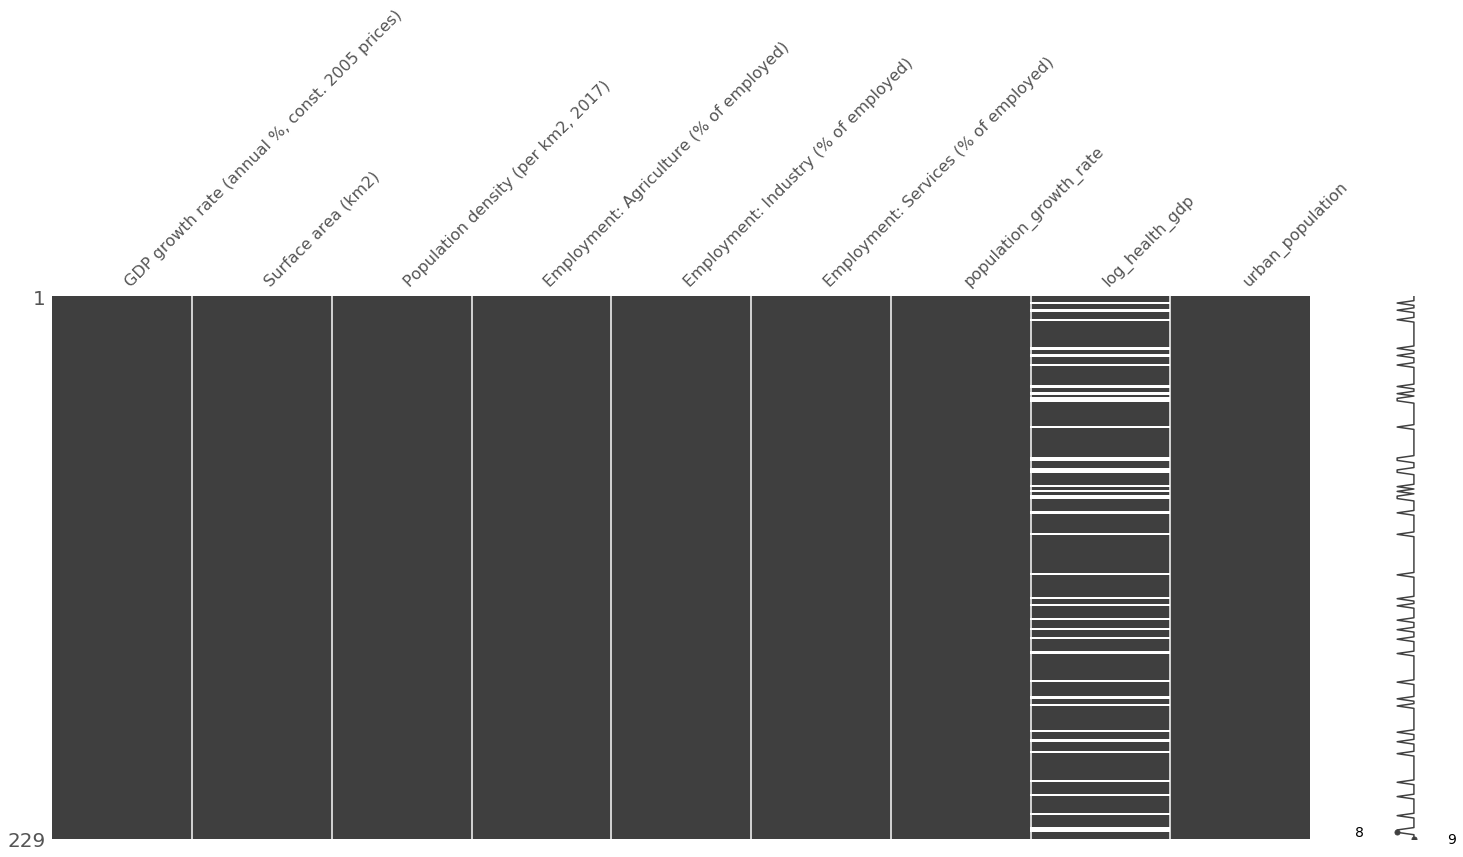

In [250]:
# Сразу проверю на пропущенные значения
import missingno as msno
%matplotlib inline
msno.matrix(X)

Да, они есть, в столбце с расходами на здравоохранение, в остальных нет. Это также видно в следующей ячейке

In [251]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 9 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   GDP growth rate (annual %, const. 2005 prices)  229 non-null    object 
 1   Surface area (km2)                              229 non-null    object 
 2   Population density (per km2, 2017)              229 non-null    float64
 3   Employment: Agriculture (% of employed)         229 non-null    object 
 4   Employment: Industry (% of employed)            229 non-null    object 
 5   Employment: Services (% of employed)            229 non-null    object 
 6   population_growth_rate                          229 non-null    int64  
 7   log_health_gdp                                  190 non-null    float64
 8   urban_population                                229 non-null    float64
dtypes: float64(3), int64(1), object(5)
memory us

In [252]:
X = X[(X[X.columns[3]]!='...')|(X[X.columns[4]]!='...')|(X[X.columns[4]]!='...')] # удаляю неизвестные значения
X = X.dropna() # удаляю пропущенные значения
# делаю так, потому что мне кажется страны слишком отличаются друг от друга, чтобы заполнять пропуски чем-то вроде среднего или медианы

In [253]:
for i in [0,1,3,4,5]:
    X[X.columns[i]] = X[X.columns[i]].apply(lambda x: float(x.replace('~', '')))

In [261]:
y = data[data['Unemployment (% of labour force)']!='...']['Unemployment (% of labour force)'].apply(lambda x: float(x))

## 3 задание

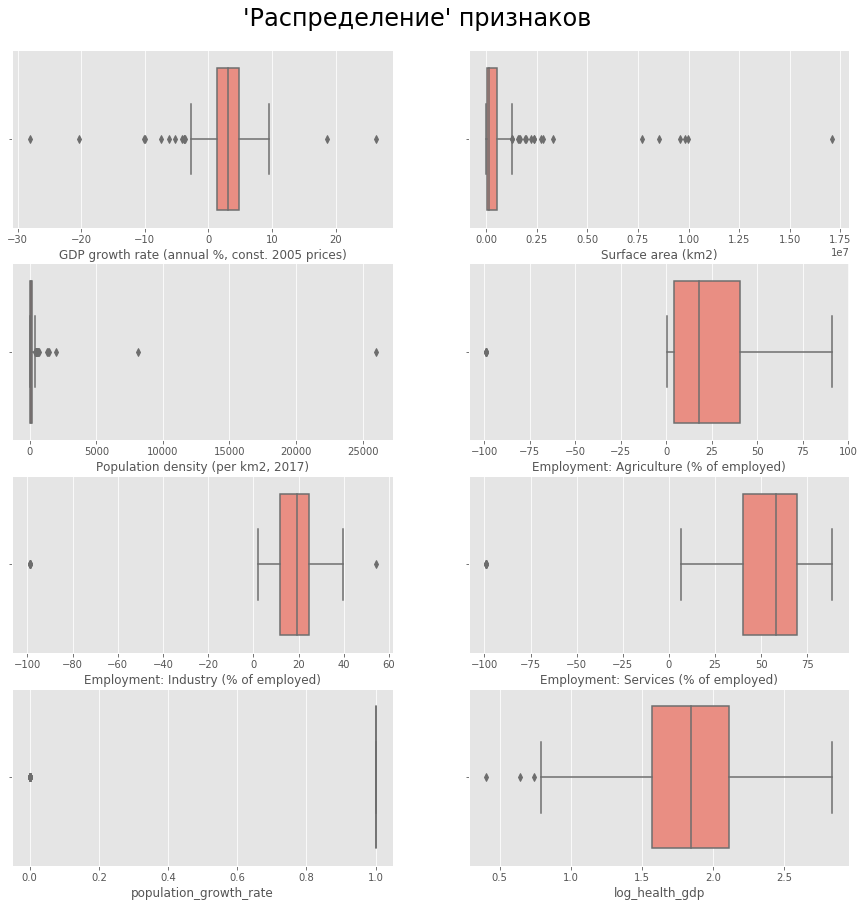

In [256]:
fig, axes = plt.subplots(4,2, figsize=(15, 15))
plt.suptitle("'Распределение' признаков", fontsize=24, y=0.92)
k = 0
for i in range(4):
    for j in range(2):
        sns.boxplot(x=X.columns[k], data=X, ax=axes[i, j], color='salmon')
        k += 1

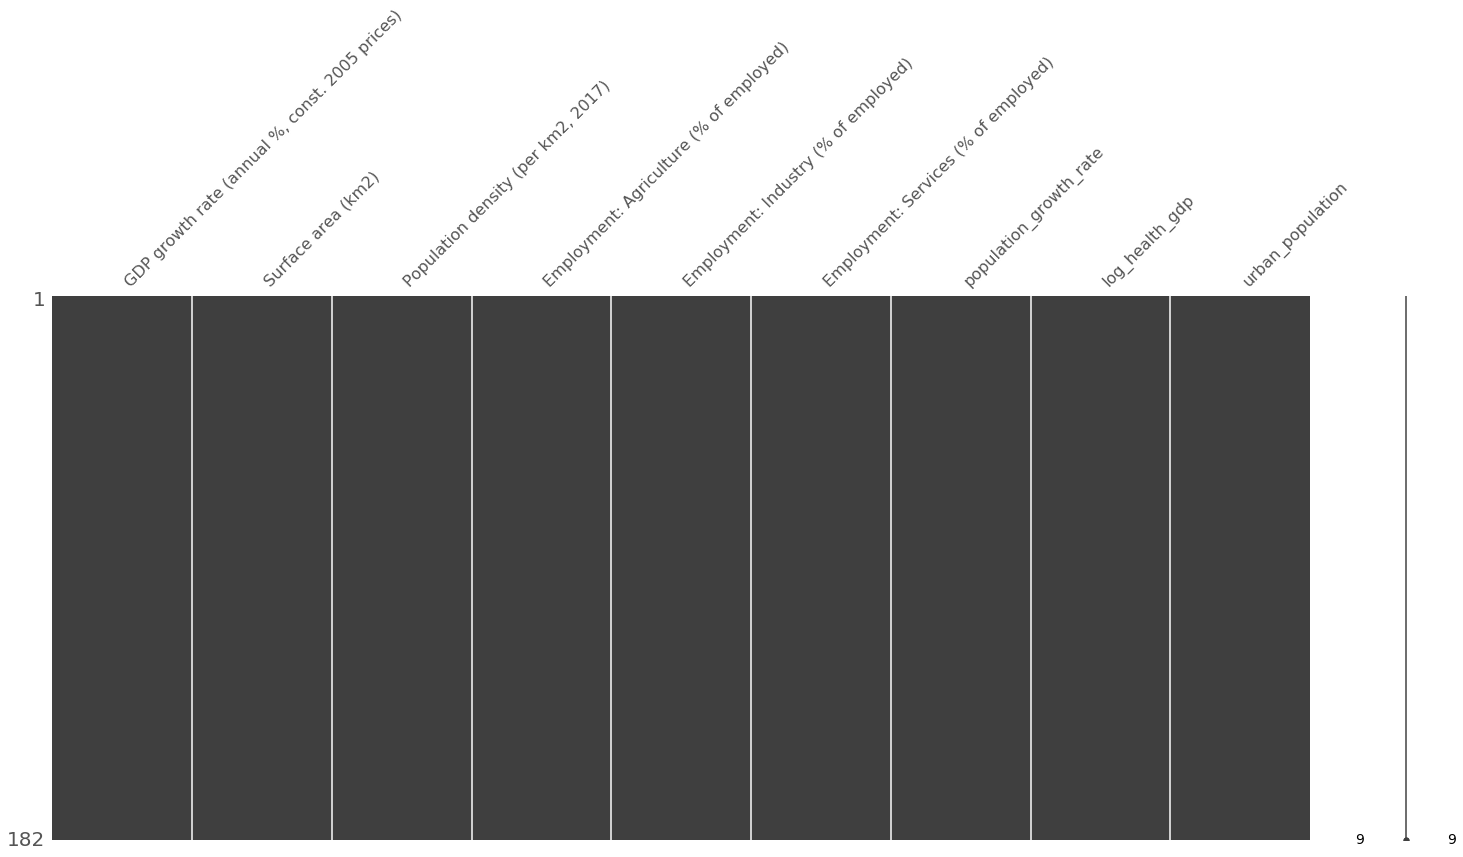

In [257]:
msno.matrix(X) # теперь пропущенных значений нет

In [258]:
# Я удалю выбросы для population_density -- у остальных ситуация еще более менее
# populaton_growth_rate -- бинарная переменная, поэтому понятно, почему у нее такая ситуация
# может быть после удаления этих станет лучше
X = X[(X[X.columns[2]]<5000)]
# еще видны значения -99 -- это наверняка пропущенные значения
X = X[(X[X.columns[3]]!=-99)|(X[X.columns[4]]!=-99)|(X[X.columns[5]]!=-99)]

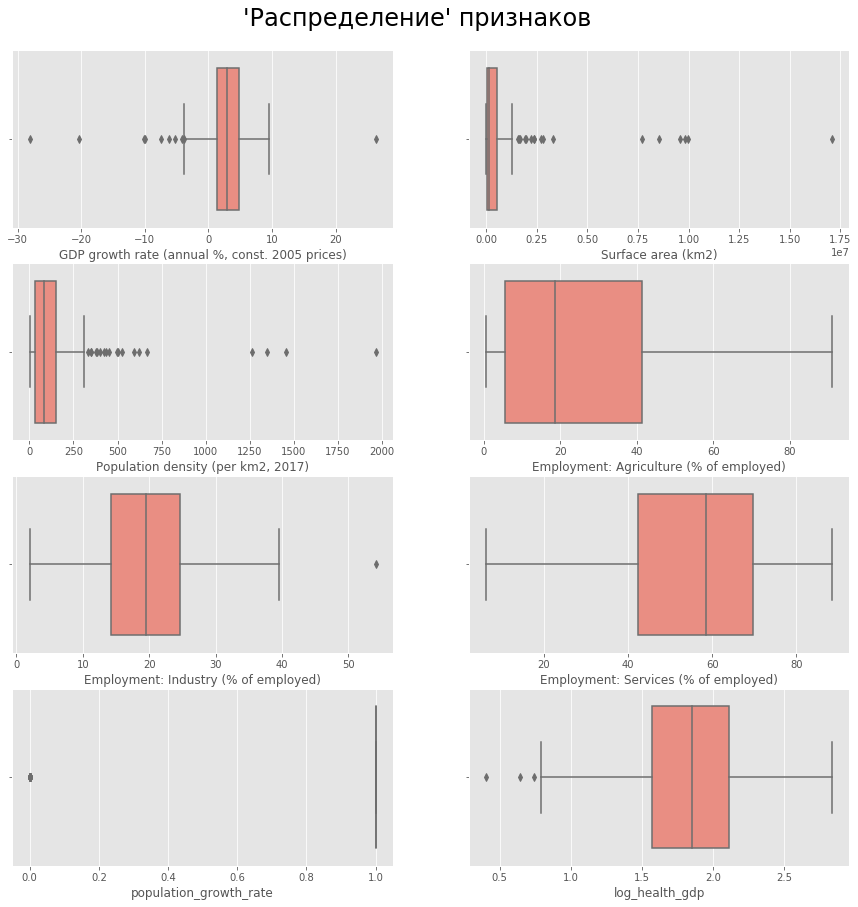

In [259]:
fig, axes = plt.subplots(4,2, figsize=(15, 15))
plt.suptitle("'Распределение' признаков", fontsize=24, y=0.92)
k = 0
for i in range(4):
    for j in range(2):
        sns.boxplot(x=X.columns[k], data=X, ax=axes[i, j], color='salmon')
        k += 1

Стало лучше, остальные признаки оставлю так, поскольку мы не можем привести все страны к одинаковому масштабу. Они слишком разные и так мы будем терять важную информацию